Uso: OUTPUT/pofv.dat  e  OUTPUT/temperature.dat
Righe totali: 600, bin unici: 30, blocchi stimati: 20


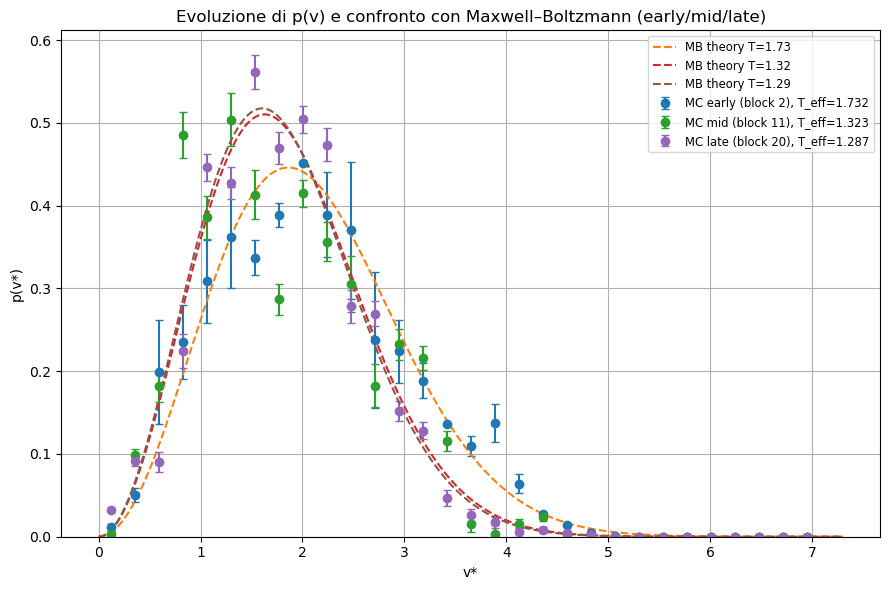

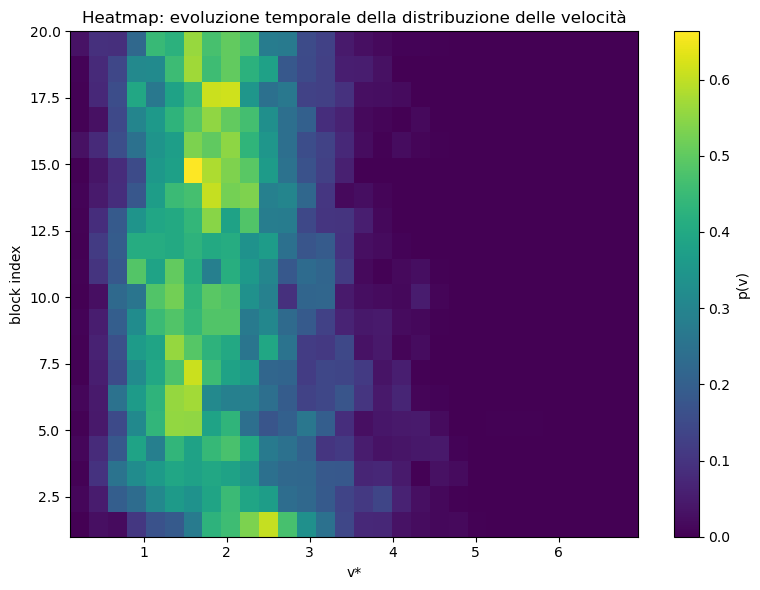

Nessun snapshot CONFIG trovato in OUTPUT/CONFIG. Per visualizzare snapshot usa write_XYZ nel main (vedi main).
Nessun snapshot CONFIG per calcolare entropia spaziale.


In [1]:
# analyze_4_02.py
# Analisi per Exercise 4.02: convergenza p(v) -> Maxwell-Boltzmann
# Usa i file prodotti dal simulatore: pofv.dat e temperature.dat (in OUTPUT or ../OUTPUT)

import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from math import pi

# ---------------------- UTILITY: path finder ----------------------
def find_output_file(fname):
    # prova percorsi possibili relativi alla cartella da cui lanci lo script
    candidates = [os.path.join("OUTPUT", fname), os.path.join("..", "OUTPUT", fname),
                  os.path.join(".", fname), os.path.join("..", fname)]
    for c in candidates:
        if os.path.isfile(c):
            return c
    raise FileNotFoundError(f"Non ho trovato {fname} in {candidates}. Assicurati che il simulatore abbia scritto il file.")

pofv_path = find_output_file("pofv.dat")
temp_path = find_output_file("temperature.dat")  # file con T effettiva per blocco

print("Uso:", pofv_path, " e ", temp_path)

# ---------------------- CARICA pofv.dat ----------------------
# formato scritto da System::averages: per ogni block appende _n_bins_v righe
# ciascuna riga: v_center  average  sum_average  err
data = np.loadtxt(pofv_path)
if data.ndim == 1:
    data = data.reshape((1, -1))  # caso singola riga (improbabile)

v_centers_unique = np.unique(data[:,0])
nbins = len(v_centers_unique)
nlines = data.shape[0]
if nlines % nbins != 0:
    print("Attenzione: numero righe in pofv.dat non multiplo di nbins dedotto. Proseguo comunque cercando di inferire nbins.")
nblocks = nlines // nbins
print(f"Righe totali: {nlines}, bin unici: {nbins}, blocchi stimati: {nblocks}")

# ricostruiamo un array blocks x bins x 4 (v, average, sum_average, err)
# assumiamo che l'ordine sia: block0 bins k=0..nbins-1, block1 bins ...
blocks_data = data.reshape((nblocks, nbins, data.shape[1]))

# estrai v_centers (ordinati)
v_centers = blocks_data[0,:,0]

# ---------------------- CARICA temperature.dat ----------------------
# format: blk  actual_T  T_ave  error  (stampa fatta in averages)
temp_data = np.loadtxt(temp_path)
# gestiamo formato rows x cols
if temp_data.ndim == 1:
    temp_data = temp_data.reshape((1, -1))
# assumiamo che colonna 1 (index 1) contenga la temperatura "actual" per blocco
# alcune versioni: columns: blk, actual_T, average_T, err_T. Usiamo la colonna 1 se esiste.
if temp_data.shape[1] >= 2:
    T_block = temp_data[:,1]
else:
    # fallback: prendi la colonna 0 (se il file è solo temperatura)
    T_block = temp_data[:,0]
if len(T_block) != nblocks:
    print("Warning: number of temperature rows != number of pofv blocks. Cerco di allineare (prendo min).")
    nblocks_common = min(len(T_block), nblocks)
    T_block = T_block[:nblocks_common]
    blocks_data = blocks_data[:nblocks_common,:,:]
    nblocks = nblocks_common

# ---------------------- funzioni teoriche ----------------------
def maxwell_boltzmann_3d(v, T):
    # p(v,T) in unità ridotte: (1/(2πT)^(3/2)) * 4π v^2 exp(-v^2/(2T))
    pref = (1.0 / ( (2.0 * np.pi * T)**1.5 ))
    return pref * 4.0 * np.pi * v**2 * np.exp(-v**2 / (2.0 * T))

# ---------------------- funzioni di utilità ----------------------
def normalize_pdf(v, pdf):
    # normalizza numericamente con trapz
    area = np.trapz(pdf, v)
    if area == 0:
        return pdf, area
    return pdf/area, area

# ---------------------- SELEZIONE blocchi da plottare ----------------------
# prendi 3 istanti: early, mid, late (evita i primissimi se vuoi scartare equil.)
early_idx = max(0, int(0.05 * nblocks))    # 5% come "early" (puoi cambiare)
mid_idx   = int(0.5 * nblocks)
late_idx  = nblocks - 1

sel_idxs = [early_idx, mid_idx, late_idx]
sel_labels = ['early', 'mid', 'late']

# ---------------------- PLOT: convergenza p(v) ----------------------
plt.figure(figsize=(9,6))
v_theo = np.linspace(0, v_centers.max()*1.05, 400)

for idx, label in zip(sel_idxs, sel_labels):
    block = blocks_data[idx,:,:]  # nbins x cols
    v = block[:,0]
    pdf_raw = block[:,1]    # average nel file (se non normalizzato, lo normalizziamo)
    err_raw = block[:,3]    # err
    # normalizza numericamente
    pdf, area = normalize_pdf(v, pdf_raw)
    # normalizza errore coerentemente (assumiamo err_raw ~ std, scala per area)
    if area != 0:
        err = err_raw / area
    else:
        err = err_raw * 0.0

    T_eff = T_block[idx]
    p_theory = maxwell_boltzmann_3d(v_theo, T_eff)

    plt.errorbar(v, pdf, yerr=err, fmt='o', label=f"MC {label} (block {idx+1}), T_eff={T_eff:.3f}", capsize=3)
    plt.plot(v_theo, p_theory, '--', label=f"MB theory T={T_eff:.2f}")

plt.xlabel("v*")
plt.ylabel("p(v*)")
plt.title("Evoluzione di p(v) e confronto con Maxwell–Boltzmann (early/mid/late)")
plt.ylim(bottom=0)
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------- PLOT: serie temporale (heatmap) delle distribuzioni per tutti i blocchi ----------------------
# costruisci matrice nblocks x nbins di pdf normalizzati
pdf_matrix = np.zeros((nblocks, nbins))
for i in range(nblocks):
    v = blocks_data[i,:,0]
    pdf_raw = blocks_data[i,:,1]
    pdf_norm, _ = normalize_pdf(v, pdf_raw)
    pdf_matrix[i,:] = pdf_norm

plt.figure(figsize=(8,6))
extent = [v_centers[0], v_centers[-1], 1, nblocks]
plt.imshow(pdf_matrix, aspect='auto', origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='p(v)')
plt.xlabel('v*')
plt.ylabel('block index')
plt.title('Heatmap: evoluzione temporale della distribuzione delle velocità')
plt.tight_layout()
plt.show()

# ---------------------- OPTIONAL: plot 3d snapshots delle config (se ci sono) ----------------------
# cerca file CONFIG se sono stati scritti (config_*.xyz)
cfg_candidates = glob.glob(os.path.join("OUTPUT","CONFIG","config_*.xyz")) + glob.glob(os.path.join("..","OUTPUT","CONFIG","config_*.xyz"))
cfg_candidates = sorted(cfg_candidates)
if len(cfg_candidates) > 0:
    # prendi 3 snapshot early/mid/late se disponibili
    picks = []
    picks.append(cfg_candidates[0])
    picks.append(cfg_candidates[len(cfg_candidates)//2])
    picks.append(cfg_candidates[-1])
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    fig = plt.figure(figsize=(12,4))
    for i,cfg in enumerate(picks):
        data = np.loadtxt(cfg, skiprows=2)  # .xyz format: first 2 lines header
        x = data[:,1]; y = data[:,2]; z = data[:,3]
        ax = fig.add_subplot(1,3,i+1, projection='3d')
        ax.scatter(x, y, z, s=10)
        ax.set_title(os.path.basename(cfg))
        ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
    plt.tight_layout()
    plt.show()
else:
    print("Nessun snapshot CONFIG trovato in OUTPUT/CONFIG. Per visualizzare snapshot usa write_XYZ nel main (vedi main).")

# ---------------------- OPTIONAL: misura 'entropia spaziale' su griglia ----------------------
def spatial_entropy_from_xyz(x,y,z, ngrid=8):
    # bin positions into ngrid^3 voxels and compute Shannon entropy of occupancy
    Hs = []
    # normalize coords to [0,1] using box side if available (assume positions are in absolute coordinates)
    # here we compute histogram
    H = 0.0
    Hs = None
    try:
        H, edges = np.histogramdd(np.vstack((x,y,z)).T, bins=(ngrid,ngrid,ngrid))
        probs = H.flatten()
        probs = probs[probs>0] / np.sum(H)
        ent = -np.sum(probs * np.log(probs))
        return ent
    except Exception as e:
        return None

# se trovi snapshot, calcola entropia e plot vs time
if len(cfg_candidates) > 0:
    ents = []
    labels = []
    for cfg in cfg_candidates:
        data = np.loadtxt(cfg, skiprows=2)
        ent = spatial_entropy_from_xyz(data[:,1], data[:,2], data[:,3], ngrid=6)
        ents.append(ent)
        labels.append(os.path.basename(cfg))
    plt.figure(figsize=(8,4))
    plt.plot(range(len(ents)), ents, 'o-')
    plt.xlabel('snapshot index (time)')
    plt.ylabel('spatial entropy (Shannon) on 6^3 grid')
    plt.title('Evoluzione entropia spaziale (proxy)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Nessun snapshot CONFIG per calcolare entropia spaziale.")


Uso file: OUTPUT/kinetic_energy.dat OUTPUT/potential_energy.dat OUTPUT/temperature.dat
Salvato: energy_progressive.png


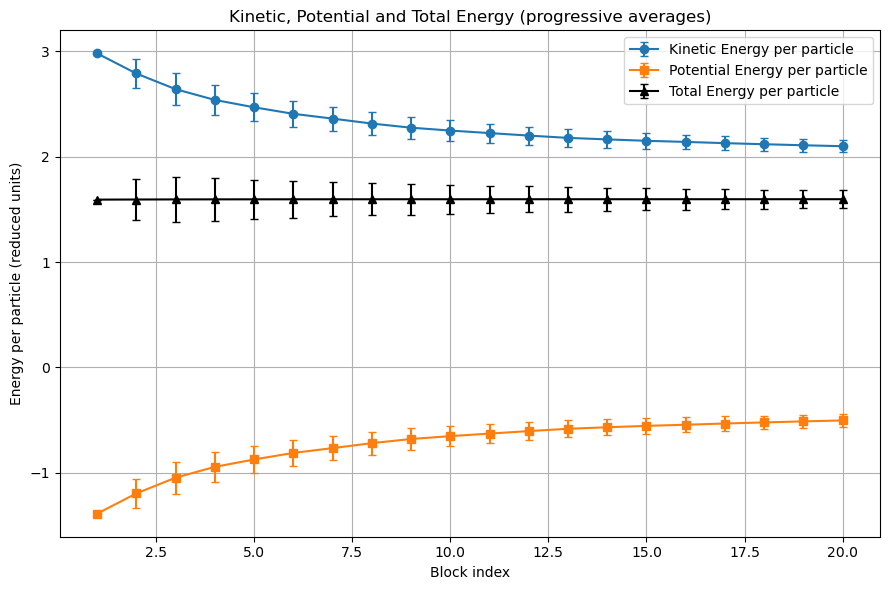

Salvato: temperature_progressive.png


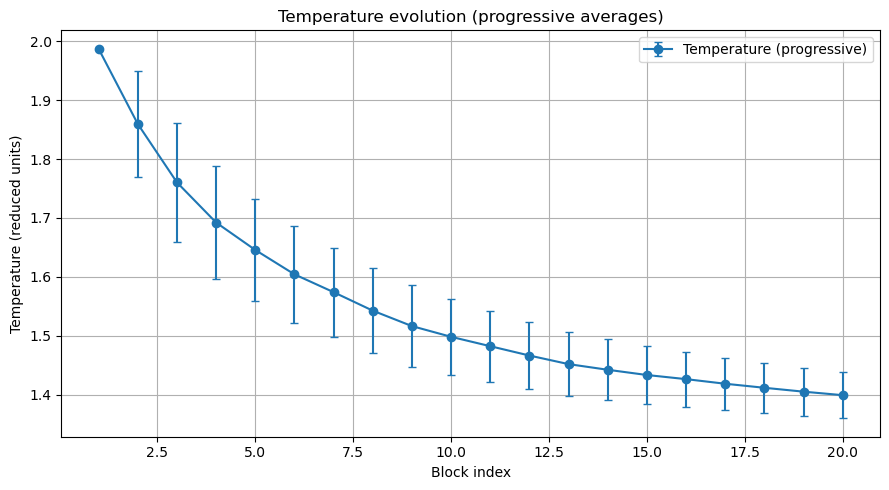


Ultimi valori (block 20):
Kinetic (prog,err) = 2.09921 0.0586928
Potential (prog,err) = -0.50297 0.0589019
Total   (prog,err) = 1.5962399999999999 0.08315214125595324
Temperature (prog,err) = 1.39947 0.0391285


In [2]:
#!/usr/bin/env python3
# analyze_energies.py
# Analisi progressive (data-blocking) di Kinetic, Potential e Temperature
# Richiede i file in OUTPUT/: kinetic_energy.dat, potential_energy.dat, temperature.dat
# Formato atteso (per riga): block  block_avg  progressive_avg  progressive_err

import numpy as np
import matplotlib.pyplot as plt
import os

def find_file(name):
    candidates = [os.path.join("OUTPUT", name), os.path.join("..","OUTPUT", name),
                  name, os.path.join("..", name)]
    for c in candidates:
        if os.path.isfile(c):
            return c
    raise FileNotFoundError(f"File {name} non trovato nei percorsi: {candidates}")

def load_progressive_file(path):
    """
    Carica un file con righe: blk, avg_block, avg_prog, err_prog
    Ritorna: blocks (1..N), avg_prog (col2), err_prog (col3)
    """
    data = np.loadtxt(path)
    if data.ndim == 1:
        data = data.reshape((1,-1))
    blocks = data[:,0].astype(int)
    avg_prog = data[:,2]
    err_prog = data[:,3]
    return blocks, avg_prog, err_prog

# ---- trova i file ----
try:
    kin_f = find_file("kinetic_energy.dat")
    pot_f = find_file("potential_energy.dat")
    temp_f = find_file("temperature.dat")
except FileNotFoundError as e:
    print(e)
    raise SystemExit(1)

print("Uso file:", kin_f, pot_f, temp_f)

# ---- carica dati ----
blk_k, kin_prog, kin_err = load_progressive_file(kin_f)
blk_p, pot_prog, pot_err = load_progressive_file(pot_f)
blk_t, temp_prog, temp_err = load_progressive_file(temp_f)

# allinea numero di blocchi al minimo comune (sicurezza)
nblocks = min(len(blk_k), len(blk_p), len(blk_t))
blk = blk_k[:nblocks]
kin_prog = kin_prog[:nblocks]; kin_err = kin_err[:nblocks]
pot_prog = pot_prog[:nblocks]; pot_err = pot_err[:nblocks]
temp_prog = temp_prog[:nblocks]; temp_err = temp_err[:nblocks]

# ---- total energy e propagazione errore (assumiamo indipendenza) ----
total_prog = kin_prog + pot_prog
total_err = np.sqrt( kin_err**2 + pot_err**2 )

# ---- plot Energies (K, P, Total) ----
plt.figure(figsize=(9,6))
plt.errorbar(blk, kin_prog, yerr=kin_err, fmt='o-', label='Kinetic Energy per particle', capsize=3)
plt.errorbar(blk, pot_prog, yerr=pot_err, fmt='s-', label='Potential Energy per particle', capsize=3)
plt.errorbar(blk, total_prog, yerr=total_err, fmt='^-', label='Total Energy per particle', capsize=3, color='black')
plt.xlabel('Block index')
plt.ylabel('Energy per particle (reduced units)')
plt.title('Kinetic, Potential and Total Energy (progressive averages)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.savefig('energy_progressive.png', dpi=200)
print("Salvato: energy_progressive.png")
plt.show()

# ---- plot Temperature ----
plt.figure(figsize=(9,5))
plt.errorbar(blk, temp_prog, yerr=temp_err, fmt='o-', label='Temperature (progressive)', capsize=3)
# prova a leggere TEMP da ../INPUT/input.dat e disegnare linea orizzontale se esiste
input_paths = [os.path.join("INPUT","input.dat"), os.path.join("..","INPUT","input.dat"), "input.dat", os.path.join("..","input.dat")]
temp_input_val = None
for ip in input_paths:
    if os.path.isfile(ip):
        try:
            with open(ip,'r') as f:
                for line in f:
                    toks = line.split()
                    if len(toks) >= 2 and toks[0].upper() == "TEMP":
                        try:
                            temp_input_val = float(toks[1])
                            print("Trovato TEMP in", ip, "=", temp_input_val)
                        except:
                            pass
                        break
        except:
            pass
        if temp_input_val is not None:
            break

if temp_input_val is not None:
    plt.axhline(temp_input_val, color='red', linestyle='--', label=f"T input = {temp_input_val:.3f}")

plt.xlabel('Block index')
plt.ylabel('Temperature (reduced units)')
plt.title('Temperature evolution (progressive averages)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.savefig('temperature_progressive.png', dpi=200)
print("Salvato: temperature_progressive.png")
plt.show()

# ---- OPTIONAL: diagnostica numerica ----
# Stampa gli ultimi valori per controllo rapido
print("\nUltimi valori (block {}):".format(blk[-1]))
print("Kinetic (prog,err) =", kin_prog[-1], kin_err[-1])
print("Potential (prog,err) =", pot_prog[-1], pot_err[-1])
print("Total   (prog,err) =", total_prog[-1], total_err[-1])
print("Temperature (prog,err) =", temp_prog[-1], temp_err[-1])
